#This task is done for the completion of Udacity Machine Learning Engineer Nanodegree Program
There is three task
1. Take any multi class dataset make atleast one class of them extremely rare.
2. Blur a huge ammount of data about 40%
3. Perfrom edge detection as preprocessing steps
4. Design a CNN based classification algorithm to classify Fashion Products images.


## Import libraries
Essential libraries for the completion of the project is imported here.

In [1]:
import numpy as np      # library for linear algebra, vector processing and numerical computation
import pandas as pd #library for data processing, CSV file I/O (e.g. pd.read_csv)
from scipy.signal import convolve
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import matplotlib.pyplot as plt
import cv2
from subprocess import check_output
from keras.utils import to_categorical
import tensorflow as tf
from sklearn.model_selection import train_test_split
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping
from keras.callbacks import LearningRateScheduler
# load and evaluate a saved model
from numpy import loadtxt
from keras.models import load_model
from keras import regularizers

# Any results you write to the current directory are saved as output.

#Mount the notebook with my google drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Learning rate scheduler function

In [3]:
def scheduler(epoch, lr):
...   if epoch < 10:
...     return lr
...   else:
...     return lr * tf.math.exp(-0.1)

##Non maximum suppression algorithim

In [4]:
def suppress(img, arg):
    P, Q = img.shape
    Z = np.zeros((P,Q), dtype=np.int32)
    incline = arg * 180. / np.pi
    incline[incline < 0] += 180
    for i in range(1,P-1):
        for j in range(1,Q-1):
            try:
                a = 255
                b = 255
             #Inclination angle 0
                if (0 <= incline[i,j] < 22.5) or (157.5 <= incline[i,j] <= 180):
                    a = img[i, j+1]
                    b = img[i, j-1]
             #Inclination angle 45
                elif (22.5 <= incline[i,j] < 67.5):
                    a = img[i+1, j-1]
                    b = img[i-1, j+1]
             #Inclination angle 90
                elif (67.5 <= incline[i,j] < 112.5):
                    a = img[i+1, j]
                    b = img[i-1, j]
             #Inclination angle 135
                elif (112.5 <= incline[i,j] < 157.5):
                    a = img[i-1, j-1]
                    b = img[i+1, j+1]
                if (img[i,j] >= a) and (img[i,j] >= b):
                    Z[i,j] = img[i,j]
                else:
                    Z[i,j] = 0
            except IndexError as error:
                 pass
    return Z

##Thresholding algorithim it gives two values

In [5]:
def threshold_function(img, lowThresholdRatio=0.05, highThresholdRatio=0.09):
    high_threshold = img.max() * highThresholdRatio;
    low_threshold = high_threshold * lowThresholdRatio;
    P, Q = img.shape
    res_value = np.zeros((P,Q), dtype=np.int32)
    weak = np.int32(25)
    strong = np.int32(255)
    strong_i, strong_j = np.where(img >= high_threshold)
    zeros_i, zeros_j = np.where(img < low_threshold)
    weak_i, weak_j = np.where((img <= high_threshold) & (img >= low_threshold))
    res_value[strong_i, strong_j] = strong
    res_value[weak_i, weak_j] = weak
    
    return (res_value, weak, strong)

## Hystersis thresholding

In [6]:
def hysteresis_function(img, weak, strong=255):
    P, Q = img.shape
    for k in range(1, P-1):
        for l in range(1, Q-1):
            if (img[k, l] == weak):
                try:
                    if ((img[k-1, l-1] == strong) or (img[k-1, l] == strong) or (img[k-1, l+1] == strong) or (img[k, l-1] == strong) or (img[k, l+1] == strong)
                            or (img[k+1, l-1] == strong) or (img[k+1, l] == strong) or (img[k+1, l+1] == strong)):
                        img[k, l] = strong
                    else:
                        img[k, l] = 0
                except IndexError as error:
                    pass
    return img


###### This function is for detect whether incoming image is blurry or not. I used laplacian filter to detect whether the image is blurry or not with a threshold value 100. Generally blurry images laplacian filer values are too much low below 10 and not blurry values are way bigger like 1000

In [7]:
thre = 100

def blurry(image):
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image,(28,28))
    #print(image.shape)
    return cv2.Laplacian(image, cv2.CV_32F).var()

def preprocessing(img):
    img = img.astype(np.float32)
    t = blurry(img)
    #print(t)
    if t > thre:
        img = img.astype(np.uint8)
        edges = cv2.Canny(img,100,200)
    else:
        Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
        Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
        #Calculate of x,y gradient
        Ix = convolve(img, Kx)
        Iy = convolve(img, Ky)
    #Calculate normalized gradient magnitude and theta
        g = np.hypot(Ix, Iy)
    #G = G / G.max() * 255
        theta = np.arctan2(Iy, Ix)
    #return (G, theta)
        nms = suppress(g,theta)
        #print(nms)
        edge,weak,strong = threshold_function(nms)
        #print(weak)
        edges = hysteresis_function(edge,weak=weak)
        #edges = edges > 100

    edges = edges.astype(np.float64)
    edges = cv2.resize(edges,(28,28))
    #edges = edges > 50
    return edges

### For this task I take Fashion Mnist dataset(28*28*1).
Load fashion Mnist,split it into train,validation,test. Make the labels to categorical

In [8]:
data_train = pd.read_csv(r'/content/drive/My Drive/fashion mnist/fashion-mnist_train.csv')
data_test = pd.read_csv(r'/content/drive/My Drive/fashion mnist/fashion-mnist_train.csv')

img_rows, img_cols = 28, 28
input_shape = (img_rows, img_cols, 1)

X = np.array(data_train.iloc[:, 1:])
y = to_categorical(np.array(data_train.iloc[:, 0]))

#Here we split validation data to optimiza classifier during training
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=13)

#Test data
X_test = np.array(data_test.iloc[:, 1:])
y_test = to_categorical(np.array(data_test.iloc[:, 0]))

#Plot of a random image which is not blurry

(-0.5, 27.5, 27.5, -0.5)

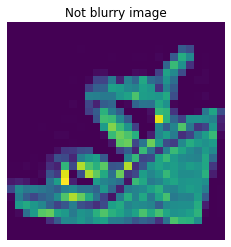

In [9]:
plt.imshow(X_val[1].reshape(28,28))
plt.title("Not blurry image")
plt.axis("off")

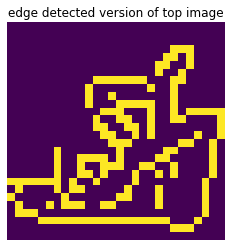

In [10]:
edge = preprocessing(X_val[1].reshape(28,28))
plt.imshow(edge)
plt.title("edge detected version of top image")
plt.axis("off");

In [11]:
np.argmax(y_train[0], axis=0),np.argmax(y_train[1], axis=0)

(7, 9)

In [12]:
np.argmax((y_train), axis=0)

array([ 2,  3,  6, 11, 13,  4,  5,  0,  8,  1])

In [13]:
temp_img1 = X_train[0]
temp_y1 = y_train[0]

temp_img2 = X_train[1]
temp_y2 = y_train[1]

In [14]:
temp_img2.shape

(784,)

In [15]:
prev_lab = []
for i in range(y_train.shape[0]):
    prev_lab.append(np.argmax(y_train[i], axis=0))    

#Seaborn count plot shows dataset presently is perfectly balanced

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


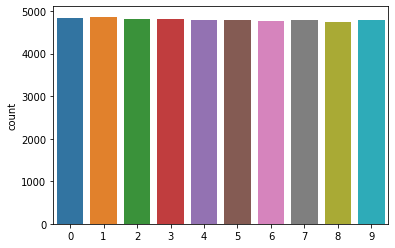

In [16]:
sns.countplot(prev_lab);

0 class imbalanced
1 class imbalanced

0: T-shirt/top
1: Trouser

#Now make the dataset extremly unbalanced.
Now change the 
*   Class 1(Trouser) to class 9
*   Class 0(Tshirt/top) to class 7 

Change the 3300 images of each class(0,1) to class 9,7


In [17]:
c = 0

for i in range(X_train.shape[0]):
    if np.argmax(y_train[i], axis=0) == 0:
        X_train[i] = temp_img1
        y_train[i] = temp_y1
        c = c + 1
        #print(str(c) + " " + str(i))
        if (c == 3300):
            print("done")
            break
        else:
            pass

c = 0

for i in range(X_train.shape[0]):
    if np.argmax(y_train[i], axis=0) == 1:
        X_train[i] = temp_img2
        y_train[i] = temp_y2
        c = c + 1
        #print(str(c) + " " + str(i))
        if (c == 3300):
            print("done")

            break
        else:
            pass

done
done


In [18]:
pre_lab = []
for i in range(y_train.shape[0]):
    pre_lab.append(np.argmax(y_train[i], axis=0))  

# Seaborn count plot shows two class is highly rare 

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


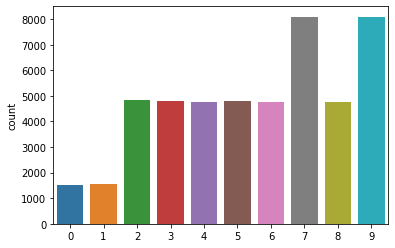

In [19]:
sns.countplot(pre_lab);

# Now the blurry part. I use gaussian blur with sigma = 1 for 40% of each class
## Then pass it through preprocessings fuction which is first detected whether the incoming image is blurry or not. IF it is not blurry then it use Canny edge filerting directly upon it. But it is blurry then we can not use canny edge filtering directly because Canny edge filter take the image then first use a gaussian kernel to blur the image. So, first step is already done for this steps. So I implement other steps as functions which is 
1. Non maximum supression
2. Thresholding
3. Hystersis thresholding

## Use this three step seperatly with hand written fuction on the blurry images
#[Canny edge detector](https://en.wikipedia.org/wiki/Canny_edge_detector)

In [20]:
X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
X_val = X_val.reshape(X_val.shape[0], img_rows, img_cols, 1)

temp1 = X_test.copy()
temp2 = X_test.copy()
blurry_x = temp1[:100]
not_blurry_x = temp2[:100]

for i in range(int(0.4*X_train.shape[0])):
    img = X_train[i]
    img = img.astype('float32')
    img = np.reshape(img,(28,28))
    img = cv2.GaussianBlur(img,(5,5),1)
    img = img.reshape(28,28,1)
    X_train[i] = img

for i in range(int(0.4*X_val.shape[0])):
    img = X_val[i]
    img = np.reshape(img,(28,28))
    img = img.astype('float32')
    img = cv2.GaussianBlur(img,(5,5),1)
    img = img.reshape(28,28,1)
    X_val[i] = img
    
for i in range(X_train.shape[0]):
    img = preprocessing(X_train[i].reshape(28,28))
    img = img.reshape(28,28,1)
    X_train[i] = img

for i in range(X_val.shape[0]):
    img = preprocessing(X_val[i].reshape(28,28))
    img = img.reshape(28,28,1)
    X_val[i] = img

for i in range(X_test.shape[0]):
    img = preprocessing(X_test[i].reshape(28,28))
    img = img.reshape(28,28,1)
    X_test[i] = img


test_y = y_test[:100]

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_val = X_val.astype('float32')
X_train /= 255
X_test /= 255
X_val /= 255

## Define the Deep learning model with sequential model

In [21]:
batch_size = 256
num_classes = 10
epochs = 50

#input image dimensions
img_rows, img_cols = 28, 28

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 kernel_initializer='he_normal',
                 input_shape=input_shape))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), activation='relu',activity_regularizer=regularizers.l2(1e-5)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), activation='relu',activity_regularizer=regularizers.l2(1e-5)))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation='relu',activity_regularizer=regularizers.l2(1e-5)))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 13, 13, 32)        128       
_________________________________________________________________
dropout (Dropout)            (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 5, 5, 64)          2

# Train it with adam optimizer

In [22]:
early = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callback = LearningRateScheduler(scheduler)

output = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=50,
          verbose=1,
          validation_data=(X_val, y_val),callbacks=[callback,early])

Epoch 1/50
188/188 [==============================] - 2s 9ms/step - loss: 0.8048 - accuracy: 0.7295 - val_loss: 0.7128 - val_accuracy: 0.7406
Epoch 2/50
188/188 [==============================] - 1s 8ms/step - loss: 0.5476 - accuracy: 0.8130 - val_loss: 0.5472 - val_accuracy: 0.8043
Epoch 3/50
188/188 [==============================] - 1s 8ms/step - loss: 0.4859 - accuracy: 0.8358 - val_loss: 0.4987 - val_accuracy: 0.8225
Epoch 4/50
188/188 [==============================] - 1s 7ms/step - loss: 0.4502 - accuracy: 0.8461 - val_loss: 0.5190 - val_accuracy: 0.8133
Epoch 5/50
188/188 [==============================] - 1s 8ms/step - loss: 0.4225 - accuracy: 0.8545 - val_loss: 0.4718 - val_accuracy: 0.8323
Epoch 6/50
188/188 [==============================] - 1s 8ms/step - loss: 0.4037 - accuracy: 0.8608 - val_loss: 0.4602 - val_accuracy: 0.8383
Epoch 7/50
188/188 [==============================] - 1s 7ms/step - loss: 0.3882 - accuracy: 0.8653 - val_loss: 0.4545 - val_accuracy: 0.8389
Epoch 

#Plot accuracy and loss plot

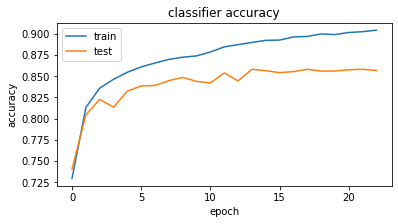

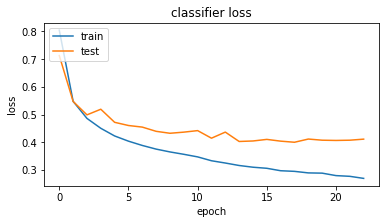

In [23]:
plt.figure(figsize=(6,3))
#history of accuracy
plt.plot(output.history['accuracy'])
plt.plot(output.history['val_accuracy'])
plt.title('classifier accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.figure(figsize=(6,3))
plt.plot(output.history['loss'])
plt.plot(output.history['val_loss'])
plt.title('classifier loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Test accuracy and loss values

In [24]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.2967435419559479
Test accuracy: 0.8966500163078308


# Now perfrom model analysis how my model perfrom on blurry and notblurry images
Take 100 image from test set, extract edges from it, then test it with model, then make them blurry and extract edges then test it with our model and print loss,accuracyv values for both cases

## A not blurry image

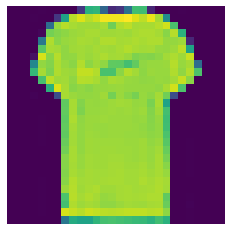

In [25]:
plt.imshow(not_blurry_x[10].reshape(28,28))
plt.axis("off");

# Extract edges from not blurry images

In [26]:
for i in range(not_blurry_x.shape[0]):
    img = preprocessing(not_blurry_x[i].reshape(28,28))
    img = img.reshape(28,28,1)
    not_blurry_x[i] = img

# Plot edges of a not blurry 

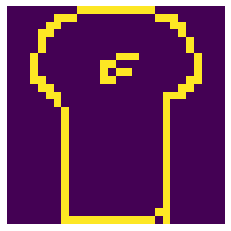

In [27]:
plt.imshow(not_blurry_x[10].reshape(28,28))
plt.axis("off");

## Blurry version of top not blurry image

(28, 28, 1)


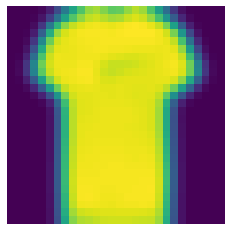

In [28]:
img = blurry_x[10]
print(img.shape)
img = img.astype(np.float32)
img = cv2.GaussianBlur(img,(5,5),1)
plt.imshow(img.reshape(28,28))
plt.axis("off");

# Plot blurry edge detected version of that image

In [29]:
for i in range(blurry_x.shape[0]):
    img = blurry_x[i]
    img = img.astype('float32')
    img = np.reshape(img,(28,28))
    img = cv2.GaussianBlur(img,(5,5),1)
    img = preprocessing(img.reshape(28,28))
    img = img.reshape(28,28,1)
    blurry_x[i] = img

# Plot edges of a blurry 

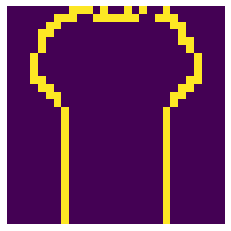

In [30]:
plt.imshow(blurry_x[10].reshape(28,28))
plt.axis("off");

## Test the model with not_blurry images,print it loss and accuracy



In [31]:
score = model.evaluate(not_blurry_x/255., test_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.310000479221344
Test accuracy: 0.9100000262260437


## Test the model with blurry images,print it loss and accuracy


In [32]:
score = model.evaluate(blurry_x/255., test_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.34263792634010315
Test accuracy: 0.8799999952316284


#Save the model as h5 file

In [33]:
#save model
model.save(r"/content/drive/My Drive/fashion mnist/model.h5")

#Load the model and test it whether it perfrom well or not

In [34]:
# load model
model = load_model("/content/drive/My Drive/fashion mnist/model.h5")

In [35]:
# summarize model.
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 13, 13, 32)        128       
_________________________________________________________________
dropout (Dropout)            (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 5, 5, 64)          2

In [36]:
score = model.evaluate(blurry_x/255., test_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.34263792634010315
Test accuracy: 0.8799999952316284
